In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import multiprocessing

# TL;DR
I perform a PCA on the pulses coordinates and take the first principal component as the neutrino's direction. The PCA is performed only on the non-auxiliary ('true') pulses if there are enough (>15); otherwise, I perform it on all the data. Then, I calculate the average time of the 'true' pulses on the negative and positive sides of the vector and flip its direction if it points to the wrong one. (lower times should be on the positive side since it is supposed to point to the source of the neutrino). This analysis is done only for the 'true' pulses since the auxiliary pulses times are too noisy for this analysis without further refinement. Validation score 1.282, LB score 1.274


# Train meta

In [2]:
train_meta = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet')
train_meta.head()

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117


In [3]:
print('Total number of events: ' + str(len(train_meta)))

Total number of events: 131953924


# Train batch 1

In [4]:
train_batch_1 = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_1.parquet')
train_batch_1.head()

,sensor_id,time,charge,auxiliary
event_id,,,,
24,3918,5928,1.325,True
24,4157,6115,1.175,True
24,3520,6492,0.925,True
24,5041,6665,0.225,True
24,2948,8054,1.575,True


In [5]:
print('Number of pulses: ' + str(len(train_batch_1)))
print('Number of events: ' + str(len(train_batch_1.index.unique())))

Number of pulses: 32792416
Number of events: 200000


# Sensor geometry

In [6]:
sensor_geometry = pd.read_csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')
sensor_geometry.head()

,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95


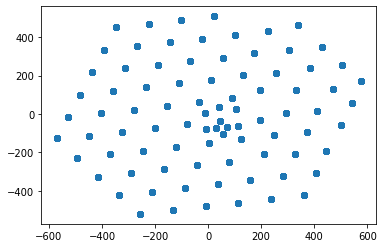

In [7]:
plt.scatter(sensor_geometry.x, sensor_geometry.y)

In [8]:
fig = px.scatter_3d(sensor_geometry, x='x', y='y', z='z', opacity=0.5)
fig.update_traces(marker_size=2)
fig.show()

# Test meta

In [9]:
test_meta = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/test_meta.parquet')
test_meta = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/test_meta.parquet')
test_meta.head()

,batch_id,event_id,first_pulse_index,last_pulse_index
0,661,2092,0,298
1,661,7344,299,334
2,661,9482,335,377


In [10]:
print(len(test_meta))

3


# Understanding the data
### I will explore event 67 (number three in train_meta) as a case event

In [11]:
case_event_idx = 3
case_event_pulses = train_batch_1.iloc[train_meta.iloc[case_event_idx].first_pulse_index.astype(int) : 
                                         train_meta.iloc[case_event_idx].last_pulse_index.astype(int)+1].copy()
print(len(case_event_pulses))
case_event_pulses.tail()

142


,sensor_id,time,charge,auxiliary
event_id,,,,
67,1890,26683,1.675,True
67,3624,26961,1.075,True
67,1928,27065,1.075,True
67,4680,27100,0.425,True
67,3772,27144,1.475,True


### Finding the coordinates of each pulse from the sensor_geometry data and mean normalizing

In [12]:
case_event_pulses = case_event_pulses.reset_index()
case_event_pulses[['x', 'y', 'z']] = sensor_geometry.loc[case_event_pulses.sensor_id].reset_index()[['x', 'y', 'z']]

case_event_pulses.x = case_event_pulses.x - case_event_pulses.x.mean()
case_event_pulses.y = case_event_pulses.y - case_event_pulses.y.mean()
case_event_pulses.z = case_event_pulses.z - case_event_pulses.z.mean()
case_event_pulses.head()

,event_id,sensor_id,time,charge,auxiliary,x,y,z
0,67,5060,6751,0.675,True,38.258521,-16.083732,-165.493873
1,67,2420,7308,0.575,True,-478.691479,47.816268,223.256127
2,67,2420,7320,0.875,True,-478.691479,47.816268,223.256127
3,67,1968,7377,0.425,True,-276.451479,-30.013732,-255.853873
4,67,2989,7655,1.375,True,624.308521,234.336268,-278.963873


### Calculating the vector of the case event from the target angles and preparing for visualisation

In [13]:
zenith_target = train_meta.iloc[case_event_idx].zenith
azimuth_target = train_meta.iloc[case_event_idx].azimuth

vector_target = [np.cos(azimuth_target) * np.sin(zenith_target), np.sin(azimuth_target) * np.sin(zenith_target),
                 np.cos(zenith_target)]

vector_base = np.array([-500, 500])
x = vector_base*vector_target[0]
y = vector_base*vector_target[1]
z = vector_base*vector_target[2]
vector_target_df = pd.DataFrame({'x': x, 'y': y, 'z': z})
vector_target_df.head()

,x,y,z
0,-311.74527,145.711308,-362.743851
1,311.74527,-145.711308,362.743851


### Many thanks to JIRKA BOROVEC for demonstrating plotly [here](https://www.kaggle.com/code/jirkaborovec/icecube-eda-3d-interactive-viewer). I was quite frustrated by the lack of pyplot interactivity in kaggle.


In [14]:
fig_auxiliary = px.scatter_3d(case_event_pulses.loc[case_event_pulses.auxiliary],
                              x='x', y='y', z='z', opacity=0.5, color_discrete_sequence=['red'])
fig_non_auxiliary = px.scatter_3d(case_event_pulses.loc[~case_event_pulses.auxiliary],
                              x='x', y='y', z='z', opacity=0.5, color_discrete_sequence=['blue'])
fig_line = px.line_3d(vector_target_df, x="x", y="y", z="z")


fig_auxiliary.update_traces(marker_size=2)
fig_non_auxiliary.update_traces(marker_size=2)

fig = go.Figure(data = fig_auxiliary.data + fig_non_auxiliary.data + fig_line.data)
fig.show()

The figure demonstrates the alignment of the angles with the 'true' pulses. Unfortunately, many events (probably most) do not have a clear pulse line like this one (hence I chose it for demonstration). Try to change case_event_idx to other numbers, then rerun the last four cells and see for yourself :)
An important thing to note is that most non-auxiliary pulses appear as a short vertical line of close dots, not because they come straight from the top but due to the structure of the detector. Watch [this](https://www.youtube.com/watch?v=iv-Rz3-s4BM) video for a better explanation, and in particular, 3:12-3:25.


### Trying a naive fitting: first principal component

In [15]:
pca = PCA(n_components=1).fit(case_event_pulses[['x', 'y', 'z']])
vector = pca.components_[0]
vector_base = np.array([-500, 500])
x = vector_base*vector[0]
y = vector_base*vector[1]
z = vector_base*vector[2]
vector_df = pd.DataFrame({'x': x, 'y': y, 'z': z})

fig_auxiliary = px.scatter_3d(case_event_pulses.loc[case_event_pulses.auxiliary],
                              x='x', y='y', z='z', opacity=0.5, color_discrete_sequence=['red'])
fig_non_auxiliary = px.scatter_3d(case_event_pulses.loc[~case_event_pulses.auxiliary],
                              x='x', y='y', z='z', opacity=0.5, color_discrete_sequence=['blue'])
fig_line = px.line_3d(vector_target_df, x="x", y="y", z="z")
fig_fit_line = px.line_3d(vector_df, x="x", y="y", z="z", color_discrete_sequence=['magenta'])

fig_auxiliary.update_traces(marker_size=2)
fig_non_auxiliary.update_traces(marker_size=2)

fig = go.Figure(data = fig_auxiliary.data + fig_non_auxiliary.data + fig_line.data + fig_fit_line.data)
fig.show()

### Let's calculate the error using [this scheme](https://www.kaggle.com/code/sohier/mean-angular-error)

In [16]:
def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)
    return np.average(np.abs(np.arccos(scalar_prod)))

In [17]:
zenith = np.arccos(vector[2])
azimuth = np.arctan2(vector[1], vector[0])
if azimuth<0:
    azimuth = 2*np.pi + azimuth

print('Predictions:')
print(f'zenith: {zenith}')
print(f'azimuth: {azimuth}')
print('Target:')
print(f'zenith: {zenith_target}')
print(f'azimuth: {azimuth_target}')
print('Error:')
print(angular_dist_score(azimuth_target, zenith_target, azimuth, zenith))

Predictions:
zenith: 0.5955780199750245
azimuth: 5.656874481284984
Target:
zenith: 0.7590535704990591
azimuth: 5.845951997240071
Error:
0.2014039002172295


# Baseline validation

The baseline strategy will be fitting a vector through only the 'true' pulses if there are enough (>15); otherwise, fitting a vector through all the data. Additionally, I will calculate the average time of the 'true' pulses on the negative and positive sides of the vector and flip its direction if it points to the wrong one. (lower times should be on the positive side since it is supposed to point to the source of the neutrino). This analysis is done only for the 'true' pulses since the auxiliary pulses times are too noisy for this analysis without further refinement.

In [18]:
train_batches = train_meta.batch_id.unique()
train_meta_baseline = train_meta.loc[train_meta.batch_id == train_batches[0]].iloc[:10000].copy()
train_meta_baseline.head()

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117


In [19]:
train_baseline = pd.read_parquet(f'/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_{str(train_batches[0])}.parquet')
train_baseline = train_baseline.iloc[:train_meta_baseline.iloc[-1].last_pulse_index.astype(int)]
train_baseline = train_baseline.reset_index()
train_baseline[['x', 'y', 'z']] = sensor_geometry.loc[train_baseline.sensor_id].reset_index()[['x', 'y', 'z']]

train_baseline['x'] = train_baseline['x'] - train_baseline.groupby('event_id').x.transform('mean')
train_baseline['y'] = train_baseline['y'] - train_baseline.groupby('event_id').y.transform('mean')
train_baseline['z'] = train_baseline['z'] - train_baseline.groupby('event_id').z.transform('mean')

print(len(train_baseline))
train_baseline.head()

1671723


,event_id,sensor_id,time,charge,auxiliary,x,y,z
0,24,3918,5928,1.325,True,291.498033,364.956393,180.170984
1,24,4157,6115,1.175,True,-157.361967,403.556393,186.320984
2,24,3520,6492,0.925,True,493.358033,287.196393,-201.009016
3,24,5041,6665,0.225,True,-21.591967,-50.183607,154.590984
4,24,2948,8054,1.575,True,564.458033,200.236393,331.470984


In [20]:
import gc
gc.collect()

3503

In [21]:
def get_angles(event_df):

    if len(event_df.loc[~event_df.auxiliary]) > 15:
        pca = PCA(n_components=2).fit(event_df.loc[~event_df.auxiliary][['x', 'y', 'z']])
    else:
        pca = PCA(n_components=2).fit(event_df[['x', 'y', 'z']])
    vector = pca.components_[0]
    
    # In order to perform time direction analysis on the non-auxiliary ('true') pulses, we neeed to mean-normalize them separately
    event_df_non_auxiliary = event_df.loc[~event_df.auxiliary].copy()
    event_df_non_auxiliary.x = event_df_non_auxiliary.x - event_df_non_auxiliary.x.mean()
    event_df_non_auxiliary.y = event_df_non_auxiliary.y - event_df_non_auxiliary.y.mean()
    event_df_non_auxiliary.z = event_df_non_auxiliary.z - event_df_non_auxiliary.z.mean()
    
    # This is the formula for calculating a distance of a point from a plane. The plane direction is the first principal component, and it goes through the origin.
    event_df_non_auxiliary['distance'] = (event_df_non_auxiliary.x*vector[0]+
                                          event_df_non_auxiliary.y*vector[1]+
                                          event_df_non_auxiliary.z*vector[2])/np.linalg.norm(vector)
    
    # Flip the vector direction if it points away from the neutrino origin
    if (event_df_non_auxiliary.loc[(~event_df_non_auxiliary.auxiliary)&(event_df_non_auxiliary.distance>0)].time.mean() >
        event_df_non_auxiliary.loc[(~event_df_non_auxiliary.auxiliary)&(event_df_non_auxiliary.distance<0)].time.mean()):
        vector = -1*vector
    
    # This is important since minor numerical deviations can give a vector component like 1.00001, and then arccos fail.
    vector = np.clip(vector, -1, 1)
    
    zenith = np.arccos(vector[2])
    azimuth = np.arctan2(vector[1], vector[0])
    if azimuth<0:
        azimuth = 2*np.pi + azimuth
    return zenith, azimuth

In [22]:
%%time

train_meta_baseline[['azimuth_pred', 'zenith_pred']] = None
for i in range(len(train_meta_baseline)):
    row = train_meta_baseline.iloc[i]
    event_df = train_baseline.iloc[row.first_pulse_index.astype(int):row.last_pulse_index.astype(int)+1].copy()
    zenith, azimuth = get_angles(event_df)
    train_meta_baseline.loc[i, 'zenith_pred'] = zenith
    train_meta_baseline.loc[i, 'azimuth_pred'] = azimuth
    
train_meta_baseline.head()

CPU times: user 2min 26s, sys: 33.9 s, total: 3min
Wall time: 2min 5s


,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith,azimuth_pred,zenith_pred
0,1,24,0,60,5.029555,2.087498,3.326427,2.011019
1,1,41,61,111,0.417742,1.549686,1.985541,0.823662
2,1,59,112,147,1.160466,2.401942,1.278074,2.611237
3,1,67,148,289,5.845952,0.759054,5.722435,0.858858
4,1,72,290,351,0.653719,0.939117,5.992344,0.384247


In [23]:
angular_dist_score(train_meta_baseline.azimuth.to_numpy(), train_meta_baseline.zenith.to_numpy(),
                   train_meta_baseline.azimuth_pred.astype(float).to_numpy(),
                   train_meta_baseline.astype(float).zenith_pred.to_numpy())

1.2819972660303094

In [24]:
del train_meta_baseline,train_baseline, train_batch_1, train_meta
gc.collect()

42

# Making a submission

In [25]:
sample_submission = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/sample_submission.parquet')
sample_submission.head()

,event_id,azimuth,zenith
0,2092,1,1
1,7344,1,1
2,9482,1,1


In [26]:
test_meta = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/test_meta.parquet')
test_meta.head()

,batch_id,event_id,first_pulse_index,last_pulse_index
0,661,2092,0,298
1,661,7344,299,334
2,661,9482,335,377


In [27]:
def load_test_batch(test_batch_id):
    test_batch = pd.read_parquet(f'/kaggle/input/icecube-neutrinos-in-deep-ice/test/batch_{str(int(test_batch_id))}.parquet')
    test_batch = test_batch.reset_index()
    test_batch[['x', 'y', 'z']] = sensor_geometry.loc[test_batch.sensor_id].reset_index()[['x', 'y', 'z']]
    test_batch['x'] = test_batch['x'] - test_batch.groupby('event_id').x.transform('mean')
    test_batch['y'] = test_batch['y'] - test_batch.groupby('event_id').y.transform('mean')
    test_batch['z'] = test_batch['z'] - test_batch.groupby('event_id').z.transform('mean')
    return test_batch

In [28]:
batches = test_meta.batch_id.unique()
for batch in batches:
    test_batch = load_test_batch(batch)
    test_meta_batch = test_meta.loc[test_meta.batch_id == batch]
    
    # multiprocessing ftw
    items = []
    for i in range(len(test_meta_batch)):
        row = test_meta_batch.iloc[i]
        items.append(test_batch.iloc[row.first_pulse_index.astype(int):row.last_pulse_index.astype(int)+1].copy())
    results = []
    with multiprocessing.Pool() as pool:
        for result in pool.map(get_angles, items):
            results.append(result)
            
    test_meta.loc[test_meta_batch.index, 'zenith'] = [results[i][0] for i in range(len(results))]
    test_meta.loc[test_meta_batch.index, 'azimuth'] = [results[i][1] for i in range(len(results))]
    
    del items, test_batch, test_meta_batch,results
    gc.collect()
test_meta.head()

,batch_id,event_id,first_pulse_index,last_pulse_index,zenith,azimuth
0,661,2092,0,298,2.299421,4.059076
1,661,7344,299,334,2.241980,2.193257
2,661,9482,335,377,2.353995,4.157449


In [29]:
submission = test_meta[['event_id', 'azimuth', 'zenith']]
submission.to_csv('submission.csv', index=False)
submission.head()

,event_id,azimuth,zenith
0,2092,4.059076,2.299421
1,7344,2.193257,2.241980
2,9482,4.157449,2.353995
